In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES']="0"
%matplotlib inline

In [2]:
# %load reader.py
import numpy as np
import skvideo.io
import skimage.transform
import csv
import collections
import os

def readShortVideo(video_path, video_category, video_name, downsample_factor=12, rescale_factor=1):
    '''
    @param video_path: video directory
    @param video_category: video category (see csv files)
    @param video_name: video name (unique, see csv files)
    @param downsample_factor: number of frames between each sampled frame (e.g., downsample_factor = 12 equals 2fps)
    @param rescale_factor: float of scale factor (rescale the image if you want to reduce computations)

    @return: (T, H, W, 3) ndarray, T indicates total sampled frames, H and W is heights and widths
    '''

    filepath = video_path + '/' + video_category
    filename = [file for file in os.listdir(filepath) if file.startswith(video_name)]
    video = os.path.join(filepath,filename[0])

    videogen = skvideo.io.vreader(video)
    frames = []
    for frameIdx, frame in enumerate(videogen):
        if frameIdx % downsample_factor == 0:
            frame = skimage.transform.rescale(frame, rescale_factor, mode='constant', preserve_range=True).astype(np.uint8)
            frames.append(frame)
        else:
            continue

    return np.array(frames).astype(np.uint8)


def getVideoList(data_path):
    '''
    @param data_path: ground-truth file path (csv files)

    @return: ordered dictionary of videos and labels {'Action_labels', 'Nouns', 'End_times', 'Start_times', 'Video_category', 'Video_index', 'Video_name'}
    '''
    result = {}

    with open (data_path) as f:
        reader = csv.DictReader(f)
        for row in reader:
            for column, value in row.items():
                result.setdefault(column,[]).append(value)

    od = collections.OrderedDict(sorted(result.items()))
    return od


In [3]:
# %load model.py
import tensorflow as tf

class Model(object):
    def __init__(self, scope_name=""):
        super().__init__()
        self.scope_name = scope_name
        self.weight_decay = 0.0
        self.para_dict = dict()
    
    def avg_pool_layer(self, bottom, name):
        return tf.nn.avg_pool(bottom, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME', name=name)

    def max_pool_layer(self, bottom, name):
        return tf.nn.max_pool(bottom, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME', name=name)
    
    def dropout_layer(self, bottom, keep_prob, is_train):
        return tf.cond(is_train, lambda: tf.nn.dropout(bottom, keep_prob=keep_prob),lambda:bottom)

    def trans_conv_layer(self, bottom, output_shape, stride, name=None, shape=None):
        if shape is not None:
            conv_filter = self.get_conv_filter(shape=shape, name=name, with_bn=False)
            conv_bias = self.get_bias(shape=shape[2], name=name)
        elif name in self.data_dict.keys():
            conv_filter = self.get_conv_filter(name=name, with_bn=False)
            conv_bias = self.get_bias(name=name)
        else:
            print("Neither give a shape nor lack a pre-trained layer called %s" % name)

        self.para_dict[name] = [conv_filter, conv_bias]
        self.weight_decay += tf.nn.l2_loss(conv_filter) + tf.nn.l2_loss(conv_bias)

        conv = tf.nn.conv2d_transpose(bottom, conv_filter, output_shape, strides=[1, stride, stride, 1], padding="SAME")
        conv = tf.nn.bias_add(conv, conv_bias)

        return conv

    def conv_layer(self, bottom, name=None, shape=None):
        if shape is not None:
            conv_filter = tf.get_variable(shape=shape, initializer=tf.truncated_normal_initializer(mean=0, stddev=0.1), name=name+"_W", dtype=tf.float32)
            conv_bias = tf.get_variable(shape=shape[2], initializer=tf.truncated_normal_initializer(mean=0, stddev=0.1), name=name+"_b", dtype=tf.float32)
        elif name in self.data_dict.keys():
            conv_filter = tf.get_variable(initializer=self.data_dict[name][0], name=name+"_W")
            conv_bias = tf.get_variable(initializer=self.data_dict[name][1], name=name+"_b")
        else:
            print("Neither give a shape nor lack a pre-trained layer called %s" % name)
            return None
        self.para_dict[name] = [conv_filter, conv_bias]
        self.weight_decay += tf.nn.l2_loss(conv_filter) + tf.nn.l2_loss(conv_bias)

        conv = tf.nn.conv2d(bottom, conv_filter, [1, 1, 1, 1], padding='SAME')
        conv = tf.nn.bias_add(conv, conv_bias)
        relu = tf.nn.relu(conv)
        return relu
    
    def flatten_layer(self, bottom):
        shape = bottom.get_shape().as_list()
        dim = 1
        for d in shape[1:]:
            dim *= d
        x = tf.reshape(bottom, [-1, dim])
        return x
    
    def dense_layer(self, bottom, shape=None, name=None):
        if shape is not None:
            weights = tf.get_variable(shape=shape, initializer=tf.random_normal_initializer(mean=0, stddev=0.02), name=name+"_W", dtype=tf.float32)
            biases = tf.get_variable(shape=shape[1], initializer=tf.constant_initializer(0.0), name=name+"_b", dtype=tf.float32)
        elif name in self.data_dict.keys():
            weights = tf.get_variable(initializer=self.data_dict[name][0], name=name+"_W")
            biases = tf.get_variable(initializer=self.data_dict[name][1], name=name+"_b")
        else:
            print("Neither give a shape nor lack a pre-trained layer called %s" % name)
            return None
        self.para_dict[name] = [weights, biases]
        self.weight_decay += tf.nn.l2_loss(weights) + tf.nn.l2_loss(biases)

        # Fully connected layer. Note that the '+' operation automatically broadcasts the biases.
        fc = tf.matmul(bottom, weights) + biases
        return fc

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
# %load extractor.py
import numpy as np
import tensorflow as tf

class Extractor(Model):
    def __init__(self, shape=(224, 224, 3), scope_name="VGG16"):
        super().__init__()
        # input information
        self.H, self.W, self.C = shape
        self.scope_name = scope_name

        # parameter dictionary
        self.para_dict = dict()
        
    def build(self, vgg16_npy_path):
        """
        load pre-trained weights from path
        :param vgg16_npy_path: file path of vgg16 pre-trained weights
        """

        # input placeholder
        self.x = tf.placeholder(tf.float32, [None, self.H, self.W, self.C])
        self.is_train = tf.placeholder(tf.bool)
        
        # Convert RGB to BGR
        red, green, blue = tf.split(axis=3, num_or_size_splits=3, value=self.x)
        self.x = tf.concat(axis=3,
                           values=[blue - 103.939,
                                   green - 116.779,
                                   red - 123.68,])
        
        assert self.x.get_shape().as_list()[1:] == [self.H, self.W, self.C]

        # load pre-trained weights
        if isinstance(vgg16_npy_path,dict):
            self.data_dict = vgg16_npy_path
            print("parameters loaded")
        else:
            self.data_dict = np.load(vgg16_npy_path, encoding='latin1').item()
            print("npy file loaded")

        ### pre-trained VGG-16 start ###
        conv1_1 = self.conv_layer( self.x, "conv1_1")
        conv1_2 = self.conv_layer(conv1_1, "conv1_2")
        pool1 = self.max_pool_layer(conv1_2, "pool1")

        conv2_1 = self.conv_layer(  pool1, "conv2_1")
        conv2_2 = self.conv_layer(conv2_1, "conv2_2")
        pool2 = self.max_pool_layer(conv2_2, "pool2")

        conv3_1 = self.conv_layer(  pool2, "conv3_1")
        conv3_2 = self.conv_layer(conv3_1, "conv3_2")
        conv3_3 = self.conv_layer(conv3_2, "conv3_3")
        pool3 = self.max_pool_layer(conv3_3, "pool3")

        conv4_1 = self.conv_layer(  pool3, "conv4_1")
        conv4_2 = self.conv_layer(conv4_1, "conv4_2")
        conv4_3 = self.conv_layer(conv4_2, "conv4_3")
        pool4   = self.max_pool_layer(conv4_3, "pool4")

        conv5_1 = self.conv_layer(  pool4, "conv5_1")
        conv5_2 = self.conv_layer(conv5_1, "conv5_2")
        conv5_3 = self.conv_layer(conv5_2, "conv5_3")
        pool5 = self.max_pool_layer(conv5_3, "pool5")
        # flatten = tf.reduce_mean(conv5_3, [1,2])
        ### pre-trained VGG-16 end ###
        
        flatten = self.flatten_layer(pool5)
        self.output = flatten

In [5]:
import numpy as np
import pandas as pd
import pickle

In [6]:
video_path = "HW5_data/TrimmedVideos/video/"
train_video_path = video_path + "train/"
valid_video_path = video_path + "valid/"

In [7]:
train_list = getVideoList("HW5_data/TrimmedVideos/label/gt_train.csv")
valid_list = getVideoList("HW5_data/TrimmedVideos/label/gt_valid.csv")

In [8]:
dtrain = pd.DataFrame.from_dict(train_list)
dvalid = pd.DataFrame.from_dict(valid_list)

In [9]:
def one_hot_encoding(arr, num_classes):
    res = np.zeros((arr.size, num_classes))
    res[np.arange(arr.size),arr] = 1
    return(res)

In [10]:
def load_frame(pkl_file):
    return pickle.load(open(pkl_file, "rb"))

In [11]:
def load_aggregate_frame(pkl_file):
    res = list()
    codes = load_frame(pkl_file)
    for i in range(len(codes)):
        res.append(np.mean(codes[i], axis=0))
    return np.array(res)

In [12]:
def load_extract_video(video_path, df, model, filename):
    print("===== read video =====")
    codes = list()
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer()) 
        for i in range(df.shape[0]):
            print(i, end="\r")
            video = readShortVideo(video_path=video_path,
                                   video_category=df.iloc[i]['Video_category'],
                                   video_name=df.iloc[i]['Video_name'],
                                   downsample_factor=12,
                                   rescale_factor=1)
            
            # extract features batch-wise
            if video.shape[0] < 50:
                tmp = sess.run(model.output, feed_dict={model.x:video})
            else:
                tmp = list()
                for i in range(int(video.shape[0]/50)+1):
                    st = 50*i
                    ed = min(50*i+50, video.shape[0])
                    tmp_video = video[st:ed,:]
                    tmp.append(sess.run(model.output, feed_dict={model.x:tmp_video}))
                tmp = np.concatenate(tmp, axis=0)
            codes.append(tmp)
    print('Done')
    
    print("===== save into %s =====" % filename)
    with open(filename, 'wb') as f:
        pickle.dump(codes, f)

# Q0. Extract 

In [ ]:
vgg16 = Extractor(shape=(240,320,3))
vgg16.build(vgg16_npy_path="updated_keras_vgg16.npy")

In [ ]:
load_extract_video(video_path=train_video_path,df=dtrain, model=vgg16, filename='train_codes_full.pkl')

In [ ]:
load_extract_video(video_path=valid_video_path,df=dvalid, model=vgg16, filename='valid_codes_full.pkl')

# Q1. Model 

In [13]:
Xtrain = load_aggregate_frame("train_codes_full.pkl")
Xtest  = load_aggregate_frame("valid_codes_full.pkl")

In [14]:
Xtrain.shape

(3236, 40960)

In [15]:
Xtest.shape

(517, 40960)

In [16]:
Ytrain = np.array(dtrain.Action_labels).astype('int32')
Ytest  = np.array(dvalid.Action_labels).astype('int32')
Ytrain = one_hot_encoding(Ytrain, 11)
Ytest = one_hot_encoding(Ytest, 11)

In [17]:
Ytrain.shape

(3236, 11)

In [18]:
Ytest.shape

(517, 11)

In [19]:
class MQ1(Model):
    def __init__(self, scope_name=""):
        super().__init__()
        self.scope_name = scope_name
        
    def build(self, input_dim, output_dim):
        with tf.variable_scope(name_or_scope=self.scope_name) as scope:
            self.x = tf.placeholder(tf.float32, shape=[None, input_dim], name="input")
            self.y = tf.placeholder(tf.int32, shape=[None, output_dim], name="output")
            self.is_train = tf.placeholder(tf.bool)
        
            fc1 = self.dense_layer(bottom=self.x, name="fc1", shape=[input_dim, 2048])
            fc1 = tf.contrib.layers.batch_norm(fc1, is_training=self.is_train, scope="bn1", decay=0.9, epsilon=1e-5, updates_collections=None, scale=True)
            fc1 = tf.nn.relu(fc1)
            
            fc2 = self.dense_layer(bottom=fc1, name="fc2", shape=[2048, 768])
            fc2 = tf.contrib.layers.batch_norm(fc2, is_training=self.is_train, scope="bn2", decay=0.9, epsilon=1e-5, updates_collections=None, scale=True)
            fc2 = tf.nn.relu(fc2)
            
            self.output = fc2
            
            self.logits = self.dense_layer(bottom=fc2, name="logits", shape=[768, output_dim])
            self.pred = tf.argmax(self.logits, axis=1, name="pred")
            
            self.true = tf.argmax(self.y, axis=1, name="true")
            self.loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=self.y, logits=self.logits, name='loss'))

            self.accuracy = tf.reduce_mean(tf.cast(tf.equal(x=self.pred, y=self.true), tf.float32))

In [20]:
scope_name = "Q1"

In [21]:
model = MQ1(scope_name=scope_name)
model.build(input_dim=Xtrain.shape[1], output_dim=Ytrain.shape[1])

In [22]:
FLAG_save_dir = 'save_Q1/'
FLAG_lr = 3e-5

In [ ]:
import os
import time
import argparse
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

def initialize_uninitialized(sess):
    global_vars = tf.global_variables()
    is_not_initialized = sess.run([tf.is_variable_initialized(var) for var in global_vars])
    not_initialized_vars = [v for (v,f) in zip(global_vars, is_not_initialized) if not f]
    if len(not_initialized_vars): 
            sess.run(tf.variables_initializer(not_initialized_vars))

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    # hyper parameters
    batch_size = 32
    epoch = 30
    early_stop_patience = 5
    min_delta = 0.0001
    opt_type = 'adam'

    # recorder
    epoch_counter = 0
    history = list()
    
    train_vars = list()
    for var in tf.trainable_variables():
        if model.scope_name in var.name:
            train_vars.append(var)
            
    # optimizer
    learning_rate = FLAG_lr
    train_op = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=0.5).minimize(model.loss, var_list=train_vars)

    # re-initialize
    initialize_uninitialized(sess)

    # reset due to adding a new task
    patience_counter = 0
    current_best_val_accu = 0
    
    saver = tf.train.Saver(tf.global_variables(), max_to_keep=1)
    checkpoint_path = os.path.join(FLAG_save_dir, 'model.ckpt')

    # optimize when the aggregated obj
    while(patience_counter < early_stop_patience and epoch_counter < epoch):

        # start training
        stime = time.time()

        train_loss, train_accu = 0.0, 0.0    
        for i in range(int(Xtrain.shape[0]/batch_size)):
            st = i*batch_size
            ed = (i+1)*batch_size
            loss, accu , _, logits = sess.run([model.loss, model.accuracy, model.logits, train_op],
                                feed_dict={model.x: Xtrain[st:ed],
                                            model.y: Ytrain[st:ed],
                                          model.is_train:True})
            train_loss += loss
            train_accu += accu
        train_loss = train_loss/(Xtrain.shape[0]/batch_size)
        train_accu = train_accu/(Xtrain.shape[0]/batch_size)
        
        val_loss, val_accu = 0.0, 0.0
        for i in range(int(Xtest.shape[0]/batch_size)):
            st = i*batch_size
            ed = (i+1)*batch_size
            loss, accu , logits = sess.run([model.loss, model.accuracy, model.logits],
                                feed_dict={model.x: Xtest[st:ed],
                                            model.y: Ytest[st:ed],
                                          model.is_train:False})
            val_loss += loss
            val_accu += accu
        val_loss = val_loss/(Xtest.shape[0]/batch_size)
        val_accu = val_accu/(Xtest.shape[0]/batch_size)
        
        print("Epoch %s (%s), %s sec >> train loss: %.4f, train accu: %.4f, val loss: %.4f, val accu: %.4f" % (epoch_counter, patience_counter, round(time.time()-stime,2), train_loss, train_accu, val_loss, val_accu))
        history.append([train_loss, train_accu, val_loss, val_accu])
        
        # early stopping check
        if (val_accu - current_best_val_accu) > min_delta:
            current_best_val_accu = val_accu
            patience_counter = 0
            saver.save(sess, checkpoint_path, global_step=epoch_counter)
            print("save in %s" % checkpoint_path)
            para_dict = sess.run(model.para_dict)
            np.save(os.path.join(FLAG_save_dir, "para_dict.npy"), para_dict)
            print("save in %s" % os.path.join(FLAG_save_dir, "para_dict.npy"))
        else:
            patience_counter += 1

        # shuffle Xtrain and Ytrain in the next epoch
        idx = np.random.permutation(Xtrain.shape[0])
        Xtrain, Ytrain = Xtrain[idx,:], Ytrain[idx,:]

        # epoch end
        epoch_counter += 1


In [ ]:
df = pd.DataFrame(history)
df.columns = ['train_loss', 'train_accu', 'val_loss', 'val_accu']
df[['train_loss', 'val_loss']].plot()
plt.savefig(os.path.join(FLAG_save_dir, 'loss.png'))
df[['train_accu', 'val_accu']].plot()
plt.savefig(os.path.join(FLAG_save_dir, 'accu.png'))

In [ ]:
FLAG_save_dir = 'save_Q1/'

In [ ]:
model = MQ1(scope_name=scope_name)
model.build(input_dim=Xtrain.shape[1], output_dim=Ytrain.shape[1])

In [23]:
import matplotlib.pyplot as plt

INFO:tensorflow:Restoring parameters from save_Q1/model.ckpt-12
Model restored save_Q1/model.ckpt-12
Initialized
save p1_valid.txt
save cnn_tsne.png


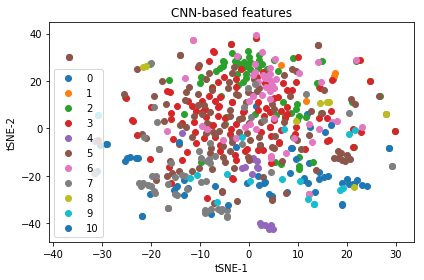

In [25]:
def initialize_uninitialized(sess):
    global_vars = tf.global_variables()
    is_not_initialized = sess.run([tf.is_variable_initialized(var) for var in global_vars])
    not_initialized_vars = [v for (v,f) in zip(global_vars, is_not_initialized) if not f]
    if len(not_initialized_vars): 
            sess.run(tf.variables_initializer(not_initialized_vars))

with tf.Session() as sess:
    if FLAG_save_dir is not None:
        sess.run(tf.global_variables_initializer())
        saver = tf.train.Saver()
        ckpt = tf.train.get_checkpoint_state(FLAG_save_dir)

        if ckpt and ckpt.model_checkpoint_path:
            saver.restore(sess, ckpt.model_checkpoint_path)
            print("Model restored %s" % ckpt.model_checkpoint_path)
            sess.run(tf.global_variables())
        else:
            print("No model checkpoint in %s" % FLAG_save_dir)
    else:
        sess.run(tf.global_variables_initializer())
        sess.run(tf.global_variables())
    print("Initialized")

    pred, cnn_output = sess.run([model.pred, model.output],
                        feed_dict={model.x: Xtest,
                                  model.is_train:False})
    
    print("save p1_valid.txt")
    np.savetxt(X=pred.astype(int), fname='p1_valid.txt',fmt='%s')
    
    from sklearn.manifold import TSNE
    cnn_tsne = TSNE(n_components=2, perplexity=30.0, random_state=5566).fit_transform(cnn_output)
    
    print("save cnn_tsne.png")
    labels = np.array(dvalid.Action_labels).astype('int32')
    plt.figure(0)
    for i in range(Ytest.shape[1]):
        xplot = cnn_tsne[np.where(labels==i)[0]]
        plt.scatter(xplot[:,0], xplot[:,1], label=i)
    plt.legend()
    plt.title("CNN-based features")
    plt.xlabel("tSNE-1")
    plt.ylabel("tSNE-2")
    plt.tight_layout()
    plt.show()
    plt.tight_layout()
    plt.savefig('cnn_tsne.png')

# Q2 modeling 

In [13]:
def pad_feature_maxlen(feature_list, max_len):
    pad_feature_list = list()
    seq_end_index = list()
    for feature in feature_list:
        feature_len = feature.shape[0]
        if feature_len < max_len:
            padded = np.zeros([max_len-feature_len, feature.shape[1]])
            seq_end_index.append(feature_len) # due to zero-indexing in Python
            pad_feature_list.append(np.concatenate([feature, padded]))
        else:
            sample_index = np.linspace(0, feature_len-1, num=max_len, dtype=np.int32)
            seq_end_index.append(max_len) # due to zero-indexing in Python
            pad_feature_list.append(feature[sample_index,:])
    
    return np.array(pad_feature_list), np.array(seq_end_index)

In [14]:
xtrain = load_frame("train_codes_full.pkl")
xtest = load_frame("valid_codes_full.pkl")

In [15]:
class MQ2(Model):
    def __init__(self, scope_name=""):
        super().__init__()
        self.scope_name = scope_name
        
    def build(self, lstm_units, max_seq_len, input_dim, output_dim):
        with tf.variable_scope(name_or_scope=self.scope_name) as scope:
            self.x = tf.placeholder(tf.float32, shape=[None, max_seq_len, input_dim], name='input')
            self.y = tf.placeholder(tf.int32, shape=[None, output_dim], name='output')
            self.seq_end_index = tf.placeholder(tf.int32, shape=[None], name='seq_end_index')
            self.is_train = tf.placeholder(tf.bool)
            
            # get batch size
            self.input_dim = input_dim
            self.output_dim = output_dim
            self.max_seq_len = max_seq_len
            self.lstm_units = lstm_units
            self.batch_size = tf.shape(self.x)[0]

            # stacked rnn cell
            cells = [tf.contrib.rnn.BasicLSTMCell(num_units=n, forget_bias=1.0) for n in lstm_units]

            stacked_rnn_cell = tf.contrib.rnn.MultiRNNCell(cells)
      
            # dynamic_rnn
            step_rnn_output, step_rnn_state = tf.nn.dynamic_rnn(stacked_rnn_cell,
                                                                self.x,
                                                                sequence_length=self.seq_end_index,
                                                                dtype=tf.float32)
            # shape meaning: batch, step, feature
            print(step_rnn_output.get_shape().as_list())
            
            # make output in shape, step x batch, feature 
            step_rnn_output = tf.reshape(step_rnn_output, [-1, self.lstm_units[1]])
            print(step_rnn_output.get_shape().as_list())
            
            # select the output at step*50*i + seq_end_index[i]
            output_index = tf.range(0, self.batch_size)*self.max_seq_len + self.seq_end_index - 1
            
            #for i in seq_end_index
            self.rnn_output = tf.gather(step_rnn_output, output_index)
            print(self.rnn_output.get_shape().as_list())
            
            self.rnn_output = self.dropout_layer(bottom=self.rnn_output, keep_prob=0.8, is_train=self.is_train)
            
            fc1 = self.dense_layer(bottom=self.rnn_output, name="fc1", shape=[self.lstm_units[-1], 512])
            fc1 = tf.contrib.layers.batch_norm(fc1, is_training=self.is_train, scope="bn1", decay=0.9, epsilon=1e-5, updates_collections=None, scale=True)
            fc1 = tf.nn.relu(fc1)
            
            self.logits = self.dense_layer(bottom=fc1, name='logits', shape=[512, self.output_dim])
            self.loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=self.y, logits=self.logits, name='loss'))
            
            
            self.pred = tf.argmax(self.logits, axis=1, name="pred")
            self.true = tf.argmax(self.y, axis=1, name="true")
            self.accuracy = tf.reduce_mean(tf.cast(tf.equal(x=self.pred, y=self.true), tf.float32))

In [16]:
ytrain = np.array(dtrain.Action_labels).astype('int32')
ytest  = np.array(dvalid.Action_labels).astype('int32')

In [17]:
Ytrain = one_hot_encoding(ytrain, 11)
Ytest = one_hot_encoding(ytest, 11)

In [18]:
FLAG_save_dir = 'save_Q2/'
FLAG_lr = 5e-5

In [19]:
scope_name = "M2"

In [20]:
model = MQ2(scope_name=scope_name)
model.build(lstm_units=[1024, 1024], max_seq_len=25, input_dim= 40960, output_dim=11)

[None, 25, 1024]
[None, 1024]
[None, 1024]


In [ ]:
import os
import time
import argparse
import numpy as np
import tensorflow as tf

def initialize_uninitialized(sess):
    global_vars = tf.global_variables()
    is_not_initialized = sess.run([tf.is_variable_initialized(var) for var in global_vars])
    not_initialized_vars = [v for (v,f) in zip(global_vars, is_not_initialized) if not f]
    if len(not_initialized_vars): 
            sess.run(tf.variables_initializer(not_initialized_vars))

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    # hyper parameters
    batch_size = 32
    epoch = 50
    early_stop_patience = 10
    min_delta = 0.0001
    opt_type = 'adam'

    # recorder
    epoch_counter = 0
    history = list()

    
    train_vars = list()
    for var in tf.trainable_variables():
        if model.scope_name in var.name:
            train_vars.append(var)
    
    # optimizer
    learning_rate = FLAG_lr
    train_op = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=0.5).minimize(model.loss, var_list=train_vars)

    # re-initialize
    initialize_uninitialized(sess)

    # reset due to adding a new task
    patience_counter = 0
    current_best_val_accu = 0
    
    saver = tf.train.Saver(tf.global_variables(), max_to_keep=1)
    checkpoint_path = os.path.join(FLAG_save_dir, 'model.ckpt')

    # optimize when the aggregated obj
    while(patience_counter < early_stop_patience and epoch_counter < epoch):

        # start training
        stime = time.time()

        train_loss, train_accu = 0.0, 0.0    
        for i in range(int(len(xtrain)/batch_size)):
            st = i*batch_size
            ed = (i+1)*batch_size
            Xtrain, Xtrain_end_index = pad_feature_maxlen(xtrain[st:ed], max_len=model.max_seq_len)
            
            # process R
            _, loss, accu , logits = sess.run([train_op, model.loss, model.accuracy, model.logits],
                                feed_dict={model.x: Xtrain,
                                            model.y: Ytrain[st:ed],
                                           model.seq_end_index: Xtrain_end_index,
                                          model.is_train:True})
            train_loss += loss
            train_accu += accu
        train_loss = train_loss/(len(xtrain)/batch_size)
        train_accu = train_accu/(len(xtrain)/batch_size)
        
        val_loss, val_accu = 0.0, 0.0
        for i in range(int(len(xtest)/batch_size)):
            st = i*batch_size
            ed = (i+1)*batch_size
            Xtest, Xtest_end_index = pad_feature_maxlen(xtest[st:ed], max_len=model.max_seq_len)
            loss, accu , logits = sess.run([model.loss, model.accuracy, model.logits],
                                feed_dict={model.x: Xtest,
                                            model.y: Ytest[st:ed],
                                           model.seq_end_index: Xtest_end_index,
                                          model.is_train:False})
            val_loss += loss
            val_accu += accu
        val_loss = val_loss/(len(xtest)/batch_size)
        val_accu = val_accu/(len(xtest)/batch_size)
        
        print("Epoch %s (%s), %s sec >> train loss: %.4f, train accu: %.4f, val loss: %.4f, val accu: %.4f" % (epoch_counter, patience_counter, round(time.time()-stime,2), train_loss, train_accu, val_loss, val_accu))
        history.append([train_loss, train_accu, val_loss, val_accu])
        
        # early stopping check
        if (val_accu - current_best_val_accu) > min_delta:
            current_best_val_accu = val_accu
            patience_counter = 0
            saver.save(sess, checkpoint_path, global_step=epoch_counter)
            print("save in %s" % checkpoint_path)
            para_dict = sess.run(model.para_dict)
            np.save(os.path.join(FLAG_save_dir, "para_dict.npy"), para_dict)
            print("save in %s" % os.path.join(FLAG_save_dir, "para_dict.npy"))
        else:
            patience_counter += 1

        # shuffle Xtrain and Ytrain in the next epoch
        #idx = np.random.permutation(Xtrain.shape[0])
        #Xtrain, Xtrain_end_index, Ytrain = Xtrain[idx,:], Xtrain_end_index[idx], Ytrain[idx,:]

        # epoch end
        epoch_counter += 1

    FLAG_optimizer = opt_type
    FLAG_lr = learning_rate
    FLAG_batch_size = batch_size
    FLAG_epoch_end = epoch_counter
    FLAG_val_accu = current_best_val_accu


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
df = pd.DataFrame(history)
df.columns = ['train_loss', 'train_accu', 'val_loss', 'val_accu']
df[['train_loss', 'val_loss']].plot()
plt.savefig(os.path.join(FLAG_save_dir, 'loss.png'))
df[['train_accu', 'val_accu']].plot()
plt.savefig(os.path.join(FLAG_save_dir, 'accu.png'))

In [21]:
def initialize_uninitialized(sess):
    global_vars = tf.global_variables()
    is_not_initialized = sess.run([tf.is_variable_initialized(var) for var in global_vars])
    not_initialized_vars = [v for (v,f) in zip(global_vars, is_not_initialized) if not f]
    if len(not_initialized_vars): 
            sess.run(tf.variables_initializer(not_initialized_vars))

with tf.Session() as sess:
    if FLAG_save_dir is not None:
        sess.run(tf.global_variables_initializer())
        saver = tf.train.Saver()
        ckpt = tf.train.get_checkpoint_state(FLAG_save_dir)

        if ckpt and ckpt.model_checkpoint_path:
            saver.restore(sess, ckpt.model_checkpoint_path)
            print("Model restored %s" % ckpt.model_checkpoint_path)
            sess.run(tf.global_variables())
        else:
            print("No model checkpoint in %s" % FLAG_save_dir)
    else:
        sess.run(tf.global_variables_initializer())
        sess.run(tf.global_variables())
    print("Initialized")


    Xtest, Xtest_end_index = pad_feature_maxlen(xtest, max_len=model.max_seq_len)
    pred, rnn_output = sess.run([model.pred, model.rnn_output],
                        feed_dict={model.x: Xtest,
                                   model.seq_end_index: Xtest_end_index,
                                  model.is_train:False})


INFO:tensorflow:Restoring parameters from save_Q2/model.ckpt-5
Model restored save_Q2/model.ckpt-5
Initialized


In [22]:
print("save p2_result.txt")
np.savetxt(X=pred.astype(int), fname='p2_result.txt',fmt='%s')

save p2_result.txt


In [35]:
from sklearn.manifold import TSNE
rnn_tsne = TSNE(n_components=2, perplexity=30.0, random_state=5566).fit_transform(rnn_output)

save rnn_tsne.png


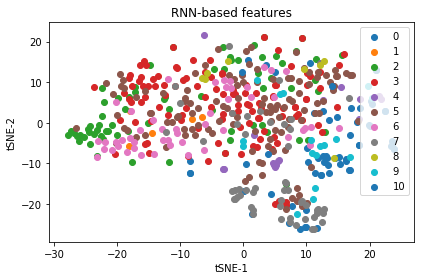

In [36]:
import matplotlib.pyplot as plt
print("save rnn_tsne.png")
labels = np.array(dvalid.Action_labels).astype('int32')
plt.figure(0)
for i in range(Ytest.shape[1]):
    xplot = rnn_tsne[np.where(labels==i)[0]]
    plt.scatter(xplot[:,0], xplot[:,1], label=i)
plt.legend()
plt.title("RNN-based features")
plt.xlabel("tSNE-1")
plt.ylabel("tSNE-2")
plt.tight_layout()
plt.show()
plt.savefig('rnn_tsne.png')